In [1]:
import torch
import wandb
import torchvision

import numpy as np

from data_generator import DataGenerator
from default_mnist_config import create_default_mnist_config
from diffusion import DiffusionRunner
from models.classifier import ResNet, ResidualBlock, ConditionalResNet

from matplotlib import pyplot as plt

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
%cd ..

/home/pasha/ml/mmp/neuralbayes/n4


In [3]:
device = torch.device('cuda')
classifier_args = {
    "block": ResidualBlock,
    "layers": [2, 2, 2, 2]
}
noisy_classifier = ConditionalResNet(**classifier_args)
noisy_classifier.to(device)

noisy_classifier.load_state_dict(torch.load('./ddpm_checkpoints/classifier_1.pth'))
noisy_classifier.eval()

clean_classifier = ResNet(**classifier_args)
clean_classifier.to(device)
clean_classifier.load_state_dict(torch.load('./ddpm_checkpoints/clean_classifier_1.pth'))
clean_classifier.eval()


ResNet(
  (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=

#### Создайте два семплемера картинок, безусловный и условный с методом .set_classifier

In [4]:
conditional_diffusion = DiffusionRunner(create_default_mnist_config(), eval=True)
conditional_diffusion.set_classifier(noisy_classifier, T=1.)

unconditional_diffusion = DiffusionRunner(create_default_mnist_config(), eval=True)

In [5]:
def get_pred_labels(images_normed: torch.Tensor):
    """
    predict labels for normed images 
    [-1, 1]
    """
    with torch.no_grad():
        logit = clean_classifier(images_normed, t=None)
        labels = torch.max(logit, dim=1)[1]
    return labels


def calc_acc_clean_classifier(images_normed: torch.Tensor, labels: torch.Tensor):
    """
    calculate accuracy using clean classifier
    """
    pred_labels = get_pred_labels(images_normed)
    ret = torch.mean((pred_labels == labels).float())

    return ret

def sample_images(diff_process, labels=None):
    images_tensor = diff_process.sample_images(batch_size=100, labels=labels)
    images_cpu = images_tensor.cpu()
    grid = torchvision.utils.make_grid(images_cpu, nrow=10).permute(1, 2, 0)
    grid = grid.data.numpy().astype(np.uint8)

    plt.imshow(grid)
    plt.show()
    return images_tensor


def cond_print_and_calc_acc(class_num: int):
    labels = class_num*torch.ones(100).long().to(device)
    images_tensor = sample_images(conditional_diffusion, labels)
    acc = calc_acc_clean_classifier((images_tensor - 127.5)/ 127.5, labels=labels)
    print('Accuracy: ', acc.item())
    return images_tensor

#### Посемплируйте наборы картинок всех классов обоими способами, изменить температуру можно с помощью повторного .set_classifier

##### Безусловная генериация

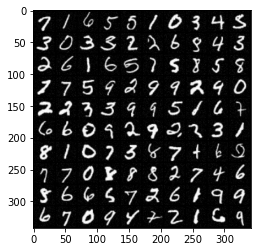

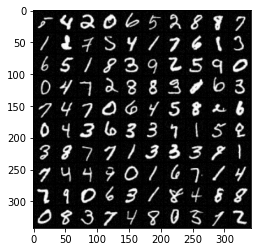

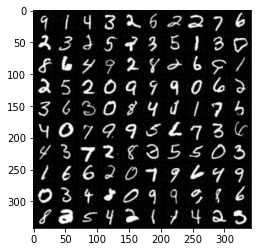

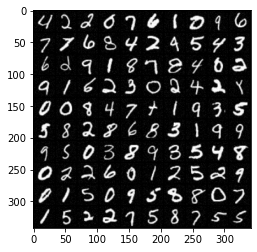

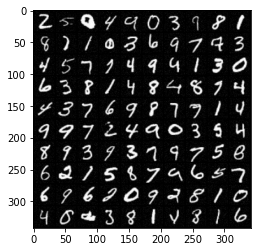

In [12]:
for _ in range(5):
    sample_images(unconditional_diffusion, labels=None)

##### Условная генерация с разной температурой

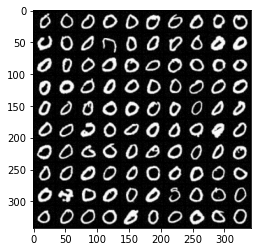

Accuracy:  0.9300000071525574


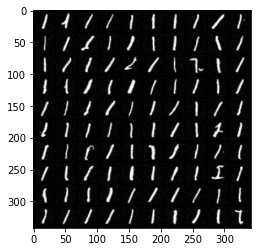

Accuracy:  0.9399999976158142


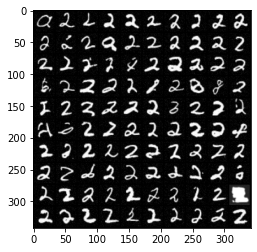

Accuracy:  0.8999999761581421


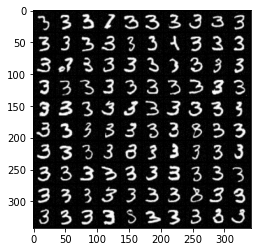

Accuracy:  0.9399999976158142


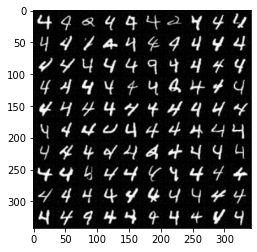

Accuracy:  0.9399999976158142


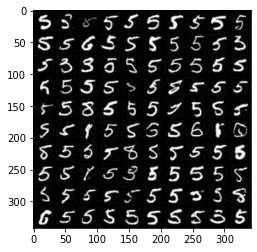

Accuracy:  0.8399999737739563


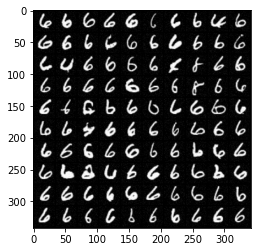

Accuracy:  0.9199999570846558


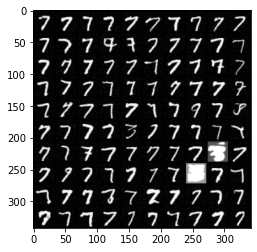

Accuracy:  0.8899999856948853


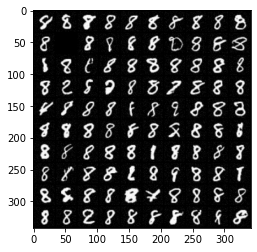

Accuracy:  0.8899999856948853


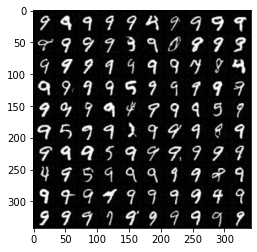

Accuracy:  0.8299999833106995


In [7]:
noisy_classifier.eval()
clean_classifier.eval()

for i in range(10):
  conditional_diffusion.set_classifier(noisy_classifier, T=0.25)
  images = cond_print_and_calc_acc(i)

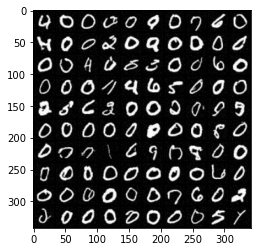

Accuracy:  0.6499999761581421


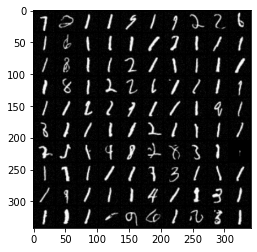

Accuracy:  0.6399999856948853


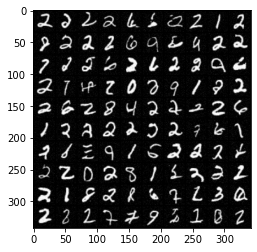

Accuracy:  0.4599999785423279


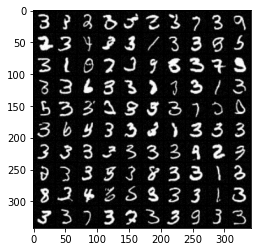

Accuracy:  0.550000011920929


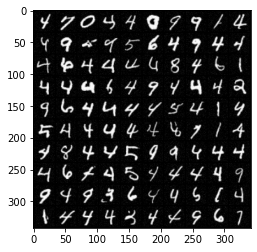

Accuracy:  0.5600000023841858


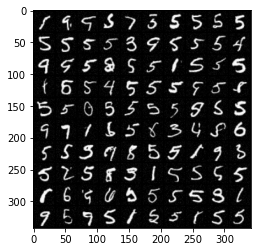

Accuracy:  0.5699999928474426


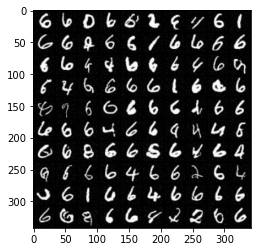

Accuracy:  0.6499999761581421


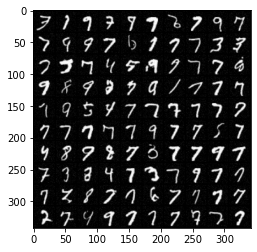

Accuracy:  0.5299999713897705


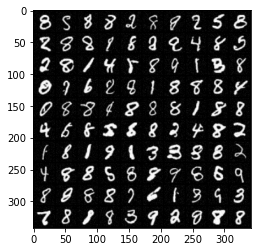

Accuracy:  0.4699999988079071


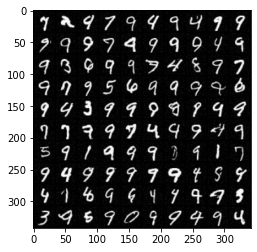

Accuracy:  0.5799999833106995


In [6]:
for i in range(10):
  conditional_diffusion.set_classifier(noisy_classifier, T=0.5)
  images = cond_print_and_calc_acc(i)

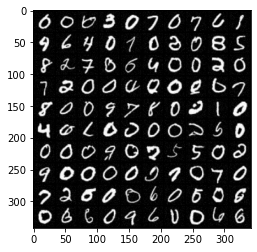

Accuracy:  0.4399999976158142


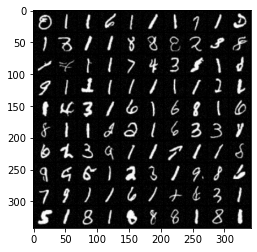

Accuracy:  0.4099999964237213


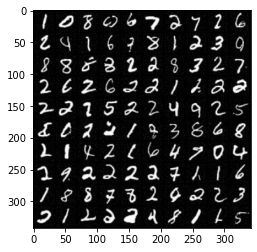

Accuracy:  0.35999998450279236


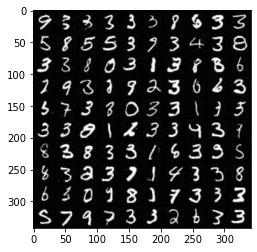

Accuracy:  0.429999977350235


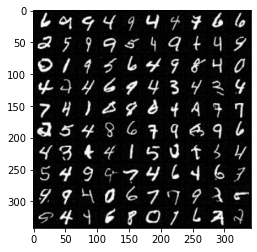

Accuracy:  0.28999999165534973


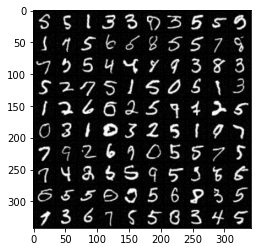

Accuracy:  0.3400000035762787


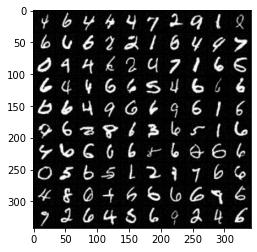

Accuracy:  0.429999977350235


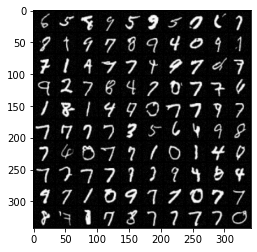

Accuracy:  0.3700000047683716


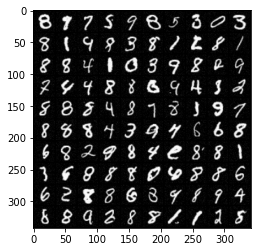

Accuracy:  0.4099999964237213


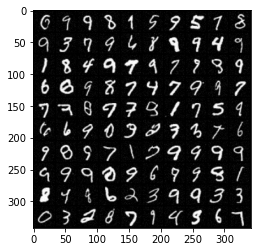

Accuracy:  0.4099999964237213


In [7]:
for i in range(10):
  conditional_diffusion.set_classifier(noisy_classifier, T=0.75)
  images = cond_print_and_calc_acc(i)

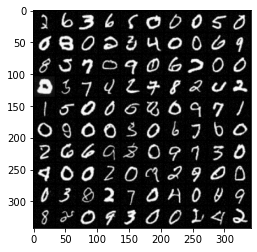

Accuracy:  0.32999998331069946


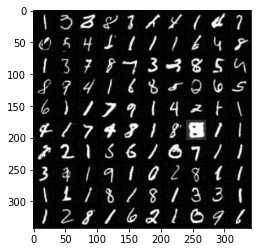

Accuracy:  0.32999998331069946


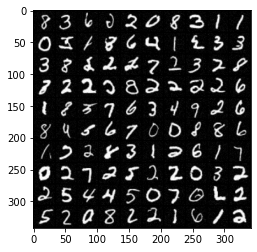

Accuracy:  0.25999999046325684


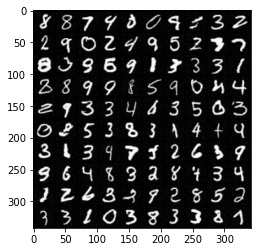

Accuracy:  0.22999998927116394


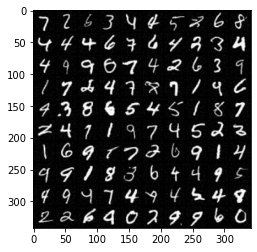

Accuracy:  0.22999998927116394


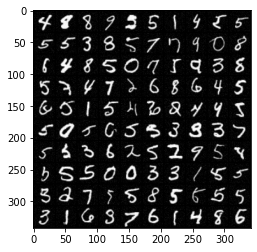

Accuracy:  0.32999998331069946


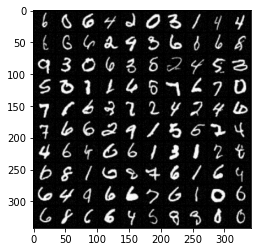

Accuracy:  0.3100000023841858


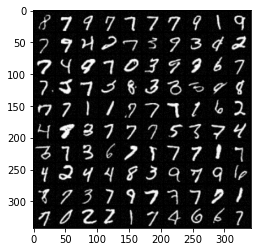

Accuracy:  0.3499999940395355


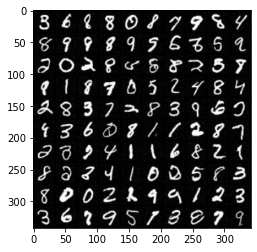

Accuracy:  0.23999999463558197


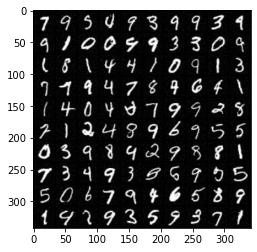

Accuracy:  0.2800000011920929


In [8]:
for i in range(10):
  conditional_diffusion.set_classifier(noisy_classifier, T=1.0)
  images = cond_print_and_calc_acc(i)

> Как сильно влияет температура на отличимость семплов при условной генерации? Продеменстрируйте для разных T свои выводы.

При увеличение Т по сетке [0.25, 0.5, 0.75, 1] обусловленность быстро падает, уже при Т=0.5 в генерацию попадает заметное количество цифр не того класса, при Т=1 же генерация не отличима от безусловной

> Какое качество получается у чистого классификатора при условной генерации? Попробуйте оценить на глаз качество чистого классификатора для безусловной генерации, объясните свои выводы.

Прослеживается следующая зависимость между температурой и качеством чистого классификатора:

|T|Accuracy|
|---|---|
|0.25| ~0.9|
|0.5 | ~0.55|
| 0.75 | ~0.35|
|1.0|~0.25|

При безусловной генерации качество очень хорошее, на глаз где-то 0.95